# ITFFC — Feature Extraction & Evaluation (FIXED)

Windows‑safe DataLoaders, flat‑folder logo support, offline weights fallback, and visible progress. Outputs saved to **`features_2/`**.

## 1) Setup & Configuration

In [1]:

# %pip install --quiet timm umap-learn scikit-learn pandas matplotlib pillow torch torchvision torchaudio

import os
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Optional deps
try:
    import timm
except Exception:
    timm = None
    print("If ViT is missing, run the pip install cell above for `timm`.")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    from umap import UMAP
except Exception:
    UMAP = None
    print("UMAP not found. Install `umap-learn` to enable it.")

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- User paths (edit if different) ---
MEDICAL_ROOT = r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\merged_balanced"
LOGO_ROOT    = r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\logo\Logos_processed"

# Toggle to True to download & use pretrained weights (requires internet)
USE_PRETRAINED = False

# Output folder (created next to this notebook by default)
FEATURES_DIR = Path.cwd() / "features_2"
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

# Image size & batch
IMG_SIZE = 224
BATCH_SIZE = 32
# Windows-safe default
NUM_WORKERS = 0
PIN_MEMORY = False

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- Path sanity checks & helpful hints ---
def ensure_dir(path_str: str, alt_candidates: List[str] = None) -> Path:
    p = Path(path_str)
    if p.exists():
        return p
    tried = [path_str]
    if alt_candidates:
        for c in alt_candidates:
            pc = Path(c)
            if pc.exists():
                print(f"[info] Provided path not found, using alternative: {pc}")
                return pc
            tried.append(c)
    parent = p.parent
    print(f"[error] Path not found: {p}")
    if parent.exists():
        print(f"       Contents of parent folder ({parent}):")
        for item in sorted(parent.iterdir()):
            print("       -", item.name)
    raise FileNotFoundError(f"None of the following paths exist: {tried}")

LOGO_ROOT = ensure_dir(
    LOGO_ROOT,
    alt_candidates=[
        r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\logo\processed",
        r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\logo\Logos",
        r"C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\logo"
    ],
)
MEDICAL_ROOT = ensure_dir(MEDICAL_ROOT)

print(f"[ok] MEDICAL_ROOT = {MEDICAL_ROOT}")
print(f"[ok] LOGO_ROOT    = {LOGO_ROOT}")
print(f"[ok] FEATURES_DIR = {FEATURES_DIR.resolve()}")


If ViT is missing, run the pip install cell above for `timm`.
UMAP not found. Install `umap-learn` to enable it.
Torch: 2.6.0+cu124
CUDA available: True
[ok] MEDICAL_ROOT = C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\merged_balanced
[ok] LOGO_ROOT    = C:\Users\bacht\Desktop\Master2_S1\ITFFC\Dataset\logo\Logos_processed
[ok] FEATURES_DIR = C:\Users\bacht\features_2


## 2) Dataset Discovery

In [2]:

from pathlib import Path
import pandas as pd

def list_class_counts(root_dir: str | Path) -> pd.DataFrame:
    root = Path(root_dir)
    if not root.exists():
        raise FileNotFoundError(f"Path not found: {root}")
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

    subdirs = [d for d in root.iterdir() if d.is_dir()]
    rows = []

    if len(subdirs) > 0:
        for cdir in sorted(subdirs, key=lambda d: d.name):
            n = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in exts)
            rows.append({"class": cdir.name, "count": n, "folder": str(cdir), "structure": "hierarchical"})
    else:
        n = sum(1 for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts)
        rows.append({"class": root.name, "count": n, "folder": str(root), "structure": "flat"})

    df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
    return df

med_df = list_class_counts(MEDICAL_ROOT)
logo_df = list_class_counts(LOGO_ROOT)

print("Medical classes:\n", med_df, "\n")
print("Logo classes:\n", logo_df, "\n")

LOGO_IS_FLAT = (logo_df.loc[0, "structure"] == "flat")
print(f"[info] LOGO_IS_FLAT = {LOGO_IS_FLAT}")


Medical classes:
                     class  count  \
0            Lung_Opacity   6012   
1  Lung_Opacity_synthetic   4180   
2            MildDemented    896   
3  MildDemented_synthetic   9296   
4                  normal  10192   

                                              folder     structure  
0  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...  hierarchical  
1  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...  hierarchical  
2  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...  hierarchical  
3  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...  hierarchical  
4  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...  hierarchical   

Logo classes:
              class  count                                             folder  \
0  Logos_processed   1435  C:\Users\bacht\Desktop\Master2_S1\ITFFC\Datase...   

  structure  
0      flat   

[info] LOGO_IS_FLAT = True


## 3) Transforms & Dataloaders

In [3]:

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

common_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class FlatImageFolder(Dataset):
    def __init__(self, root: str | Path, transform=None, exts=None):
        self.root = Path(root)
        self.transform = transform
        self.exts = exts or {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
        self.paths = [p for p in self.root.rglob("*") if p.is_file() and p.suffix.lower() in self.exts]
        self.classes = [self.root.name]
        self.class_to_idx = {self.classes[0]: 0}
        self.samples = [(str(p), 0) for p in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = 0
        return img, label

def make_loader_hierarchical(root_dir: str | Path):
    ds = datasets.ImageFolder(root=str(root_dir), transform=common_tfms)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    return ds, dl

def make_loader_logo(root_dir: str | Path, is_flat: bool):
    if is_flat:
        ds = FlatImageFolder(root=root_dir, transform=common_tfms)
        dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    else:
        ds, dl = make_loader_hierarchical(root_dir)
    return ds, dl

med_ds, med_dl = make_loader_hierarchical(MEDICAL_ROOT)
logo_ds, logo_dl = make_loader_logo(LOGO_ROOT, LOGO_IS_FLAT)

print("Medical dataset size:", len(med_ds), " | classes:", med_ds.classes)
print("Logo dataset size:", len(logo_ds), " | classes:", logo_ds.classes)


Medical dataset size: 30576  | classes: ['Lung_Opacity', 'Lung_Opacity_synthetic', 'MildDemented', 'MildDemented_synthetic', 'normal']
Logo dataset size: 1435  | classes: ['Logos_processed']


### 3b) Visual sanity check — show sample batches

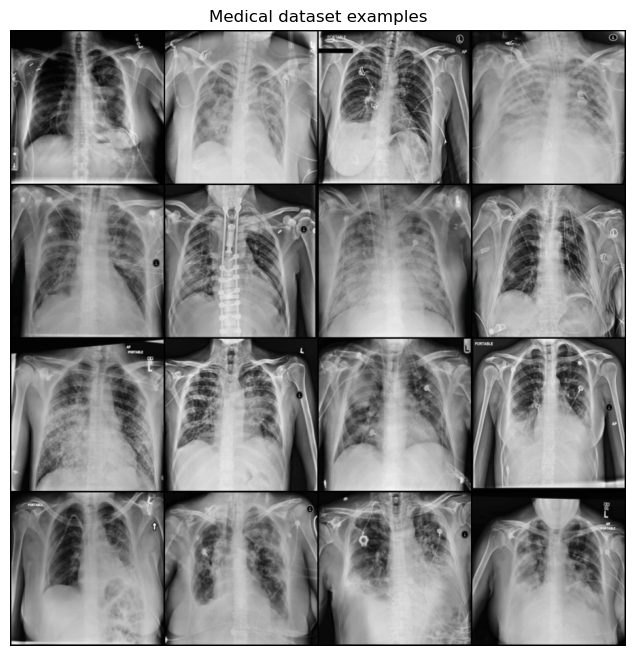

Labels: ['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity']


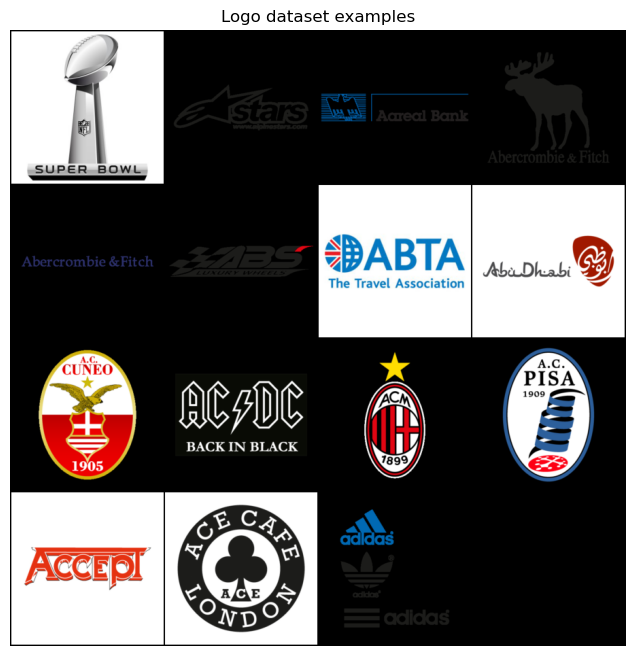

Labels: ['Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed', 'Logos_processed']


In [4]:

import numpy as np
from torchvision.utils import make_grid

def show_batch(dl, classes, n=16, title="Batch samples"):
    xb, yb = next(iter(dl))
    xb = xb[:n]; yb = yb[:n]
    img = xb.clone()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    grid = make_grid(img, nrow=int(np.sqrt(n)))
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off"); plt.title(title); plt.show()
    print("Labels:", [classes[i] for i in yb.tolist()])

show_batch(med_dl, med_ds.classes, n=16, title="Medical dataset examples")
show_batch(logo_dl, logo_ds.classes, n=16, title="Logo dataset examples")


## 4) Define Feature Extractors RES_NET50 maybe 

In [5]:

def build_resnet50_extractor(use_pretrained=False):
    if use_pretrained:
        try:
            m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        except Exception as e:
            print("[warn] Could not load pretrained ResNet50; falling back to random init:", e)
            m = models.resnet50(weights=None)
    else:
        m = models.resnet50(weights=None)
    m.fc = nn.Identity()
    m.eval().to(device)
    return m, 2048

def build_vit_extractor(use_pretrained=False):
    if timm is None:
        print("[info] timm not installed; skipping ViT.")
        return None, None
    try:
        vit = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained)
    except Exception as e:
        print("[warn] Could not load ViT pretrained:", e, "-> using random init")
        vit = timm.create_model('vit_base_patch16_224', pretrained=False)
    vit.reset_classifier(0)
    vit.eval().to(device)
    feat_dim = getattr(vit, 'num_features', 768)
    return vit, feat_dim

@torch.no_grad()
def extract_features(backbone: nn.Module, loader: DataLoader, feat_dim: int) -> np.ndarray:
    feats = np.zeros((len(loader.dataset), feat_dim), dtype=np.float32)
    ptr = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=False)
        out = backbone(xb)
        out = out.detach().cpu().numpy()
        n = out.shape[0]
        feats[ptr:ptr+n] = out
        ptr += n
    return feats

def save_features(prefix: str, ds, feats: np.ndarray, model_tag: str):
    npy_path = Path(FEATURES_DIR) / f"{prefix}_{model_tag}_features.npy"
    np.save(npy_path, feats)
    meta = pd.DataFrame({
        "path": [p[0] for p in ds.samples],
        "label_index": [p[1] for p in ds.samples],
        "label_name": [ds.classes[p[1]] for p in ds.samples]
    })
    csv_path = Path(FEATURES_DIR) / f"{prefix}_{model_tag}_meta.csv"
    meta.to_csv(csv_path, index=False)
    print(f"Saved -> {npy_path.name}  |  {csv_path.name}")

cnn, cnn_dim = build_resnet50_extractor(USE_PRETRAINED)
vit, vit_dim = build_vit_extractor(USE_PRETRAINED)

xb, yb = next(iter(med_dl))
xb = xb.to(device)
with torch.no_grad():
    out = cnn(xb)
print("[smoke] ResNet50 batch output:", tuple(out.shape))
if vit is not None:
    with torch.no_grad():
        out2 = vit(xb)
    print("[smoke] ViT batch output:", tuple(out2.shape))
else:
    print("[smoke] ViT skipped.")


[info] timm not installed; skipping ViT.
[smoke] ResNet50 batch output: (32, 2048)
[smoke] ViT skipped.


## 5) Extract & Save Features 

In [6]:

import time
from datetime import timedelta

def extract_with_progress(model, loader, feat_dim, tag):
    model.eval()
    n = len(loader.dataset)
    feats = np.zeros((n, feat_dim), dtype=np.float32)
    ptr = 0
    total = len(loader)
    t0 = time.time()
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader, 1):
            xb = xb.to(device, non_blocking=False)
            out = model(xb).detach().cpu().numpy()
            b = out.shape[0]
            feats[ptr:ptr+b] = out; ptr += b
            done = i / total
            elapsed = time.time() - t0
            eta = elapsed / max(done, 1e-9) - elapsed
            print(f"\r[{tag}] {i}/{total} ({done*100:5.1f}%) | elapsed {timedelta(seconds=int(elapsed))} | eta {timedelta(seconds=int(eta))}",
                  end="", flush=True)
    print("", flush=True)
    return feats

print("[Medical] CNN extracting...", flush=True)
med_cnn_feats = extract_with_progress(cnn, med_dl, cnn_dim, "Medical/CNN")
save_features("medical", med_ds, med_cnn_feats, "cnn")

if vit is not None:
    print("[Medical] ViT extracting...", flush=True)
    med_vit_feats = extract_with_progress(vit, med_dl, vit_dim, "Medical/ViT")
    save_features("medical", med_ds, med_vit_feats, "vit")

print("[Logo] CNN extracting...", flush=True)
logo_cnn_feats = extract_with_progress(cnn, logo_dl, cnn_dim, "Logo/CNN")
save_features("logo", logo_ds, logo_cnn_feats, "cnn")

if vit is not None:
    print("[Logo] ViT extracting...", flush=True)
    logo_vit_feats = extract_with_progress(vit, logo_dl, vit_dim, "Logo/ViT")
    save_features("logo", logo_ds, logo_vit_feats, "vit")

print("\nAll extractions completed. Files saved in:", Path(FEATURES_DIR).resolve(), flush=True)


[Medical] CNN extracting...
[Medical/CNN] 956/956 (100.0%) | elapsed 0:03:02 | eta 0:00:00
Saved -> medical_cnn_features.npy  |  medical_cnn_meta.csv
[Logo] CNN extracting...
[Logo/CNN] 45/45 (100.0%) | elapsed 0:00:08 | eta 0:00:00
Saved -> logo_cnn_features.npy  |  logo_cnn_meta.csv

All extractions completed. Files saved in: C:\Users\bacht\features_2


## 6) Feature Evaluation — Compactness/Distinctiveness + PCA/t‑SNE/UMAP

[Medical/CNN] compactness (↓): 37.8885 | distinctiveness (↑): 192.3707 | silhouette (↑): 0.2060


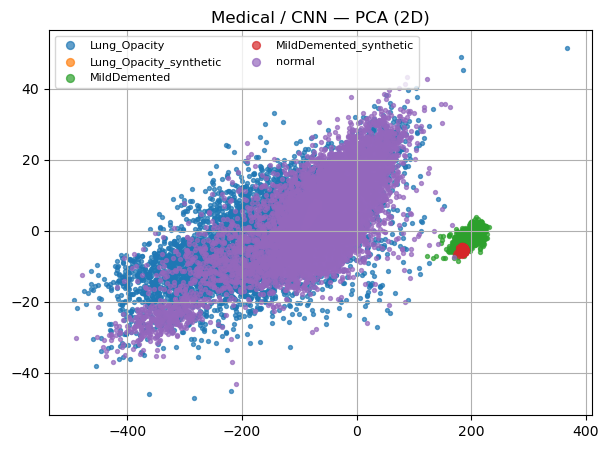

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


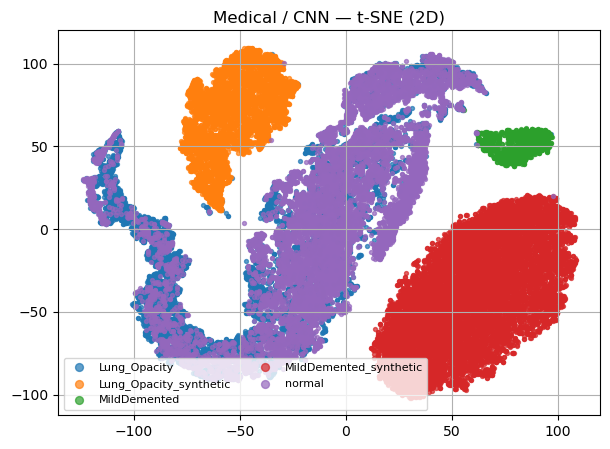

UMAP not installed; skipping.
[info] Medical ViT features not found: [Errno 2] No such file or directory: 'C:\\Users\\bacht\\features_2\\medical_vit_features.npy'
Silhouette not available: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[Logo/CNN] compactness (↓): 160.4776 | distinctiveness (↑): nan | silhouette (↑): nan


C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


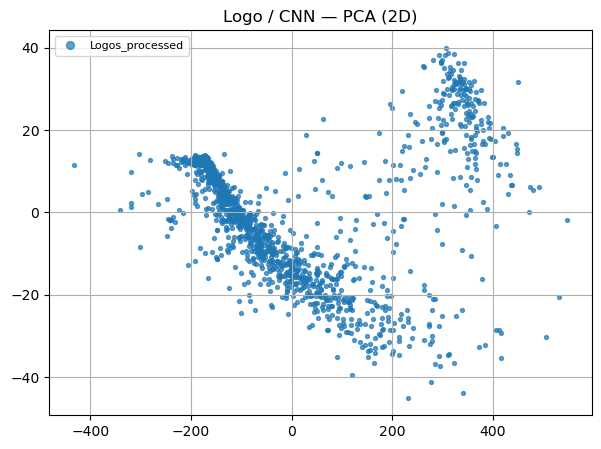

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


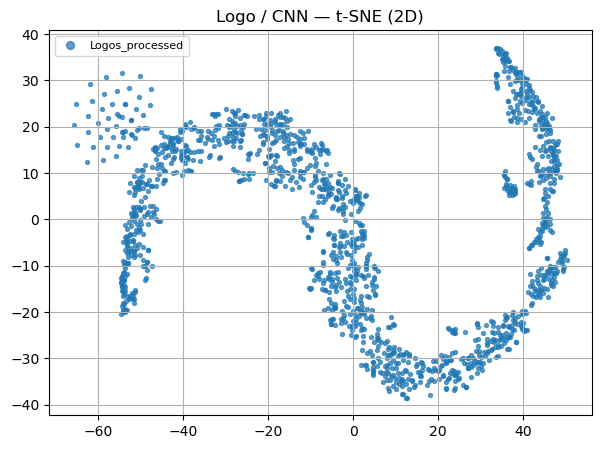

UMAP not installed; skipping.
[info] Logo ViT features not found: [Errno 2] No such file or directory: 'C:\\Users\\bacht\\features_2\\logo_vit_features.npy'


In [7]:

def class_centroids(feats: np.ndarray, labels: np.ndarray) -> Dict[int, np.ndarray]:
    cent = {}
    for c in np.unique(labels):
        cent[c] = feats[labels == c].mean(axis=0)
    return cent

def mean_intra_class_distance(feats: np.ndarray, labels: np.ndarray) -> float:
    vals = []
    for c in np.unique(labels):
        f = feats[labels == c]
        mu = f.mean(axis=0, keepdims=True)
        d = np.linalg.norm(f - mu, axis=1).mean()
        vals.append(d)
    return float(np.mean(vals))

def mean_inter_centroid_distance(feats: np.ndarray, labels: np.ndarray) -> float:
    cent = class_centroids(feats, labels)
    keys = sorted(cent.keys())
    dists = []
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            d = np.linalg.norm(cent[keys[i]] - cent[keys[j]])
            dists.append(d)
    return float(np.mean(dists))

def silhouette(feats: np.ndarray, labels: np.ndarray) -> float:
    try:
        return float(silhouette_score(feats, labels, metric="euclidean"))
    except Exception as e:
        print("Silhouette not available:", e)
        return float("nan")

def quick_report(name: str, feats: np.ndarray, labels: np.ndarray):
    comp = mean_intra_class_distance(feats, labels)
    dist = mean_inter_centroid_distance(feats, labels)
    sil  = silhouette(feats, labels)
    print(f"[{name}] compactness (↓): {comp:.4f} | distinctiveness (↑): {dist:.4f} | silhouette (↑): {sil:.4f}")
    return comp, dist, sil

def scatter_2d(X2d: np.ndarray, y: np.ndarray, classes: List[str], title: str):
    plt.figure(figsize=(7,5))
    for c_idx, c_name in enumerate(classes):
        m = (y == c_idx)
        if m.any():
            plt.scatter(X2d[m, 0], X2d[m, 1], s=8, label=c_name, alpha=0.7)
    plt.title(title)
    plt.legend(markerscale=2, fontsize=8, ncol=2)
    plt.grid(True)
    plt.show()

def do_pca_tsne_umap(prefix: str, feats: np.ndarray, labels: np.ndarray, classes: List[str]):
    pca = PCA(n_components=2, random_state=SEED)
    Xp = pca.fit_transform(feats)
    scatter_2d(Xp, labels, classes, f"{prefix} — PCA (2D)")
    tsne = TSNE(n_components=2, init="pca", random_state=SEED, perplexity=30, learning_rate="auto", n_iter=1500)
    Xt = tsne.fit_transform(feats)
    scatter_2d(Xt, labels, classes, f"{prefix} — t-SNE (2D)")
    if UMAP is not None:
        um = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
        Xu = um.fit_transform(feats)
        scatter_2d(Xu, labels, classes, f"{prefix} — UMAP (2D)")
    else:
        print("UMAP not installed; skipping.")

med_meta = pd.read_csv(Path(FEATURES_DIR) / "medical_cnn_meta.csv")
med_labels = med_meta["label_index"].to_numpy()

logo_meta = pd.read_csv(Path(FEATURES_DIR) / "logo_cnn_meta.csv")
logo_labels = logo_meta["label_index"].to_numpy()

med_cnn = np.load(Path(FEATURES_DIR) / "medical_cnn_features.npy")
logo_cnn = np.load(Path(FEATURES_DIR) / "logo_cnn_features.npy")

quick_report("Medical/CNN", med_cnn, med_labels)
do_pca_tsne_umap("Medical / CNN", med_cnn, med_labels, med_ds.classes)

try:
    med_vit = np.load(Path(FEATURES_DIR) / "medical_vit_features.npy")
    quick_report("Medical/ViT", med_vit, med_labels)
    do_pca_tsne_umap("Medical / ViT", med_vit, med_labels, med_ds.classes)
except Exception as e:
    print("[info] Medical ViT features not found:", e)

quick_report("Logo/CNN", logo_cnn, logo_labels)
do_pca_tsne_umap("Logo / CNN", logo_cnn, logo_labels, logo_ds.classes)

try:
    logo_vit = np.load(Path(FEATURES_DIR) / "logo_vit_features.npy")
    quick_report("Logo/ViT", logo_vit, logo_labels)
    do_pca_tsne_umap("Logo / ViT", logo_vit, logo_labels, logo_ds.classes)
except Exception as e:
    print("[info] Logo ViT features not found:", e)

try:
    med_vit = np.load(Path(FEATURES_DIR) / "medical_vit_features.npy")
    med_fuse = np.concatenate([med_cnn, med_vit], axis=1)
    print("Medical fused shape:", med_fuse.shape)
    quick_report("Medical/Fused", med_fuse, med_labels)
    do_pca_tsne_umap("Medical / Fused (CNN+ViT)", med_fuse, med_labels, med_ds.classes)
except Exception:
    pass

try:
    logo_vit = np.load(Path(FEATURES_DIR) / "logo_vit_features.npy")
    logo_fuse = np.concatenate([logo_cnn, logo_vit], axis=1)
    print("Logo fused shape:", logo_fuse.shape)
    quick_report("Logo/Fused", logo_fuse, logo_labels)
    do_pca_tsne_umap("Logo / Fused (CNN+ViT)", logo_fuse, logo_labels, logo_ds.classes)
except Exception:
    pass


## 7) Notes
- Features + metadata are saved under `features_2/`.
- Set `USE_PRETRAINED=True` in Cell 1 **if you have internet** to use ImageNet weights.
- On Windows, keep `NUM_WORKERS=0` to avoid deadlocks.
- Lower `BATCH_SIZE` if you hit GPU memory limits.

# CBAM modules + ResNet50 wrapper

In [8]:
# === CBAM (Convolutional Block Attention Module) + ResNet50 wrapper ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # along channel dim -> [B,1,H,W] for avg and max
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(x_cat))
        return attn

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, spatial_kernel=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio=ratio)
        self.sa = SpatialAttention(kernel_size=spatial_kernel)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class ResNet50_CBAM_Extractor(nn.Module):
    """
    Outputs a 2048-d vector (after avgpool) like the baseline extractor,
    but applies CBAM on the layer4 feature map before pooling.
    """
    def __init__(self, use_pretrained=False):
        super().__init__()
        if use_pretrained:
            try:
                backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            except Exception:
                backbone = models.resnet50(weights=None)
        else:
            backbone = models.resnet50(weights=None)

        # keep layers up to layer4 and avgpool, drop fc
        self.stem = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
        )
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.cbam   = CBAM(in_planes=2048, ratio=16, spatial_kernel=7)
        self.avgpool = backbone.avgpool  # AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)    # [B, 2048, H, W]
        x = self.cbam(x)      # refine features
        x = self.avgpool(x)   # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)
        return x

def build_resnet50_cbam_extractor(use_pretrained=False):
    m = ResNet50_CBAM_Extractor(use_pretrained=use_pretrained).to(device)
    m.eval()
    return m, 2048

# quick smoke test on one med batch (optional)
try:
    xb, yb = next(iter(med_dl))
    xb = xb.to(device)
    cbam_model, cbam_dim = build_resnet50_cbam_extractor(USE_PRETRAINED)
    with torch.no_grad():
        out = cbam_model(xb)
    print("[smoke] ResNet50+CBAM batch output:", tuple(out.shape))
except Exception as e:
    print("[warn] CBAM smoke test skipped/failed:", e)


[smoke] ResNet50+CBAM batch output: (32, 2048)


In [9]:
# === Extract & save CBAM-refined features ===
print("[Medical] CNN+CBAM extracting...", flush=True)
med_cbam_feats = extract_with_progress(cbam_model, med_dl, 2048, "Medical/CNN+CBAM")
save_features("medical", med_ds, med_cbam_feats, "cnn_cbam")

print("[Logo] CNN+CBAM extracting...", flush=True)
logo_cbam_feats = extract_with_progress(cbam_model, logo_dl, 2048, "Logo/CNN+CBAM")
save_features("logo", logo_ds, logo_cbam_feats, "cnn_cbam")

print("\nCBAM features saved to:", FEATURES_DIR.resolve())


[Medical] CNN+CBAM extracting...
[Medical/CNN+CBAM] 956/956 (100.0%) | elapsed 0:03:29 | eta 0:00:00
Saved -> medical_cnn_cbam_features.npy  |  medical_cnn_cbam_meta.csv
[Logo] CNN+CBAM extracting...
[Logo/CNN+CBAM] 45/45 (100.0%) | elapsed 0:00:09 | eta 0:00:00
Saved -> logo_cnn_cbam_features.npy  |  logo_cnn_cbam_meta.csv

CBAM features saved to: C:\Users\bacht\features_2


=== Metrics: Medical ===
[CNN] compactness (↓): 37.8885 | distinctiveness (↑): 192.3707 | silhouette (↑): 0.2060
[CNN+CBAM] compactness (↓): 41.5896 | distinctiveness (↑): 114.3193 | silhouette (↑): 0.2505

=== Metrics: Logo ===
Silhouette not available: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[CNN] compactness (↓): 160.4776 | distinctiveness (↑): nan | silhouette (↑): nan
Silhouette not available: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[CNN+CBAM] compactness (↓): 156.3155 | distinctiveness (↑): nan | silhouette (↑): nan

=== 2D projections: Medical CNN vs CNN+CBAM ===


C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bacht\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


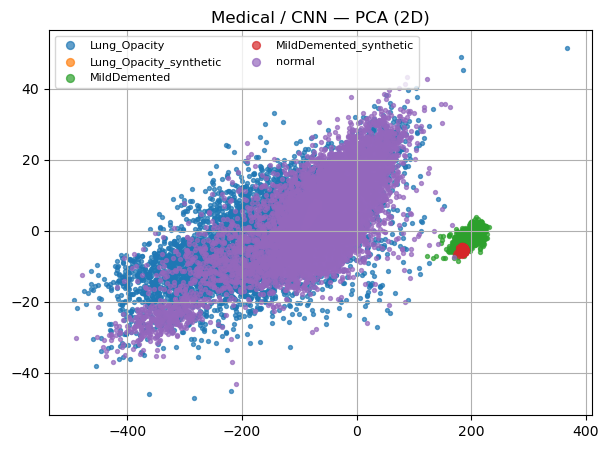

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


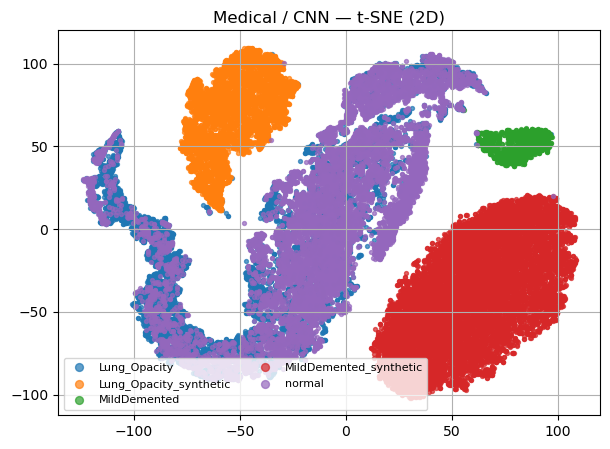

UMAP not installed; skipping.


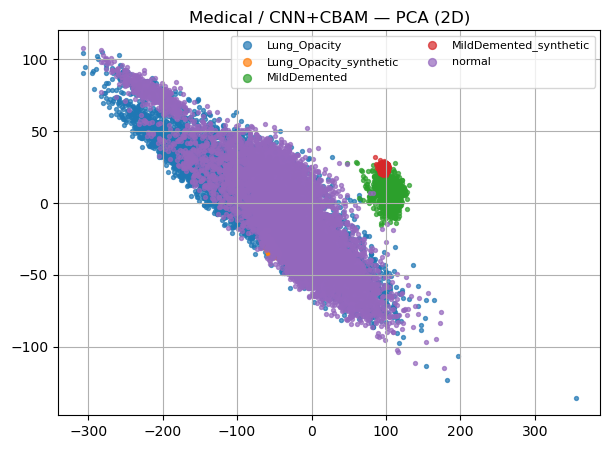

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


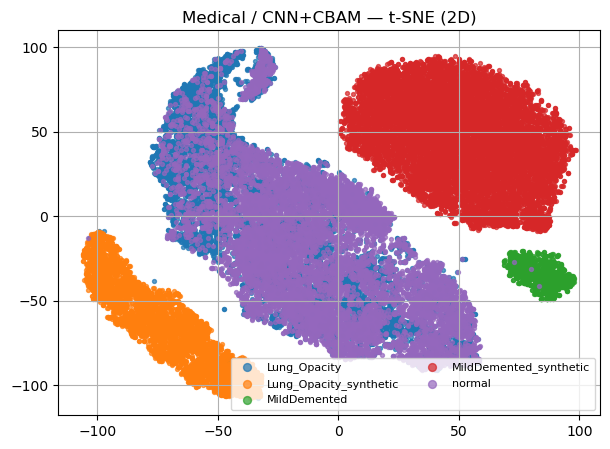

UMAP not installed; skipping.

=== 2D projections: Logo CNN vs CNN+CBAM ===


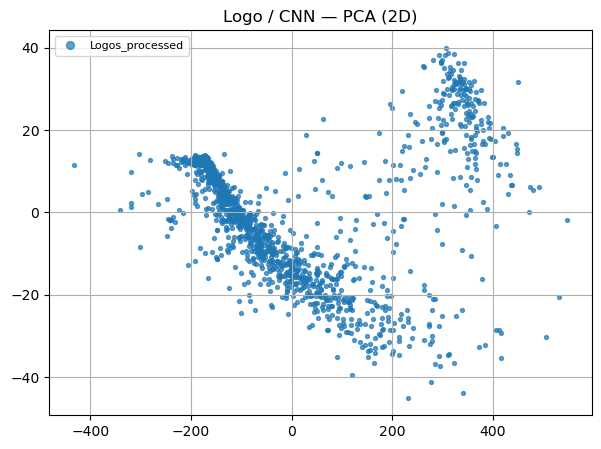

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


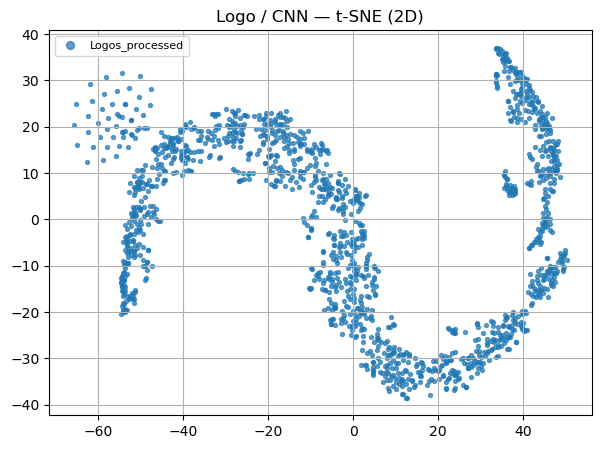

UMAP not installed; skipping.


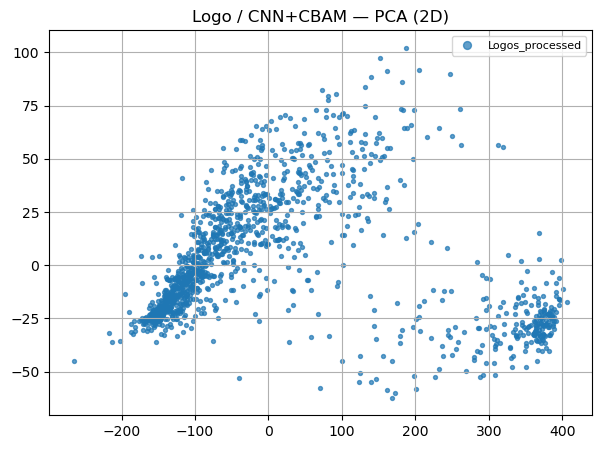

C:\Users\bacht\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


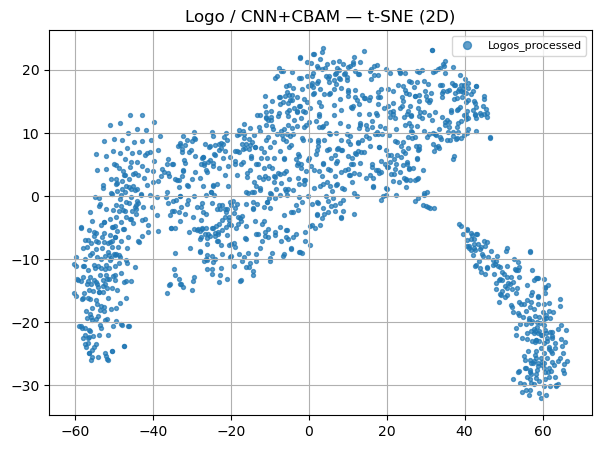

UMAP not installed; skipping.


In [10]:
# === Load saved features & compare ===
import numpy as np
import pandas as pd
from pathlib import Path

# Load labels
med_meta = pd.read_csv(Path(FEATURES_DIR) / "medical_cnn_meta.csv")
logo_meta = pd.read_csv(Path(FEATURES_DIR) / "logo_cnn_meta.csv")
med_labels = med_meta["label_index"].to_numpy()
logo_labels = logo_meta["label_index"].to_numpy()

# Baseline CNN
med_cnn = np.load(Path(FEATURES_DIR) / "medical_cnn_features.npy")
logo_cnn = np.load(Path(FEATURES_DIR) / "logo_cnn_features.npy")

# CBAM
med_cbam = np.load(Path(FEATURES_DIR) / "medical_cnn_cbam_features.npy")
logo_cbam = np.load(Path(FEATURES_DIR) / "logo_cnn_cbam_features.npy")

# ViT (optional)
have_med_vit = (Path(FEATURES_DIR) / "medical_vit_features.npy").exists()
have_logo_vit = (Path(FEATURES_DIR) / "logo_vit_features.npy").exists()
if have_med_vit:
    med_vit = np.load(Path(FEATURES_DIR) / "medical_vit_features.npy")
if have_logo_vit:
    logo_vit = np.load(Path(FEATURES_DIR) / "logo_vit_features.npy")

print("=== Metrics: Medical ===")
quick_report("CNN", med_cnn, med_labels)
quick_report("CNN+CBAM", med_cbam, med_labels)
if have_med_vit:
    quick_report("ViT", med_vit, med_labels)

print("\n=== Metrics: Logo ===")
quick_report("CNN", logo_cnn, logo_labels)
quick_report("CNN+CBAM", logo_cbam, logo_labels)
if have_logo_vit:
    quick_report("ViT", logo_vit, logo_labels)

# Visual comparisons (2D projections)
print("\n=== 2D projections: Medical CNN vs CNN+CBAM ===")
do_pca_tsne_umap("Medical / CNN", med_cnn, med_labels, med_ds.classes)
do_pca_tsne_umap("Medical / CNN+CBAM", med_cbam, med_labels, med_ds.classes)
if have_med_vit:
    print("\n=== 2D projections: Medical ViT ===")
    do_pca_tsne_umap("Medical / ViT", med_vit, med_labels, med_ds.classes)

print("\n=== 2D projections: Logo CNN vs CNN+CBAM ===")
do_pca_tsne_umap("Logo / CNN", logo_cnn, logo_labels, logo_ds.classes)
do_pca_tsne_umap("Logo / CNN+CBAM", logo_cbam, logo_labels, logo_ds.classes)
if have_logo_vit:
    print("\n=== 2D projections: Logo ViT ===")
    do_pca_tsne_umap("Logo / ViT", logo_vit, logo_labels, logo_ds.classes)
